## Visión por Computadora - Trabajo Práctico 3

### Integrantes
- Eduardo Echeverría
- Diego Braga

### Enunciado

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template.

1. Obtener una detección del logo en cada imagen sin falsos positivos
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [1]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

In [2]:
# Definimos el path a las imagenes y al template
images_path = glob.glob("./images/*")
template_path = "./template/pattern.png"

Para resolver este ejercicio se presentaron varias dificultades antes de llegar al resultado final:

1. El primer punto que se notó previo a realizar los experimentos es que los logos a detectar tienen diferentes resoluciones. Esto implicará realizar evaluaciones para diferentes escalas del template original.

2. Se realizaron varias pruebas obteniendo los bordes de las imágenes originales y del template con Canny y luego se evaluaron las métricas. Se obtuvieron buenos resultados para la métrica TM_CCORR_NORMED (correlación normalizado) pero sólo con templates realativamente grandes, lo cual no es aceptable ya que por ejemplo la imagen *coca_multi.png* presenta logos en menor resolución. Al ser dimensiones tan pequeñas, los bordes quedan muy imprecisos y resulta en falsos positivos sobre diferentes artefectos de la imagen (ej. bordes). Otro caso particular es el de la imagen *COCA-COLA-LOGO.jpg* que incluye un sombreado en las letras que requiere una configuración especial del algoritmo (Canny) que no funciona correctamente para todas las imágenes. Los mejores resultados se dieron aplicando Canny previo al escalado, dado que cv.resize aplica interpolación que mejora notoriamente las detecciones. En resumen, la utilización de Canny es viable si se utilizan o bien diferentes parametrizaciones de Canny, o diferentes métricas de evaluación dependiendo de alguna heurística que distinga cada situación de forma genérica. No fue el camino elegido dado que es muy difícil generalizarlo para futuras imágenes.

3. Los logos presentes en botellas o latas tienen la particularidad son curvadas y por lo general ninguna de las métricas daba buenos resultados en este tipo de imágenes. Se decidió que la mejor forma de evitar estos problemas es tomar sólo un porcentaje central con respecto al ancho del template (ej. 70%). Este criterio no afectaría tanto a la detección ya que captura elementos esenciales del logotipo. Se podrían haber tomado más áreas del logo para lograr más detecciones (ej. sector izquierdo o derecho), pero no se hizo para optimizar el procesado.

4. En algunos casos el logo aparece con letras oscuras sobre fondo claro, y en otros sucede lo contrario. Por lo tanto, se decidió utilizar dos variaciones del template para cada medida, una con la versión binarizada (blanco y negro) y otra con el negativo. O sea, letras negras con fondo blanco, o letras blancas con fondo negro. A pesar de que las imágenes probablemente no presenten estas intensidades extremas, es suficiente para que el algoritmo realiza la detección adecuadamente y de la forma más genérica posible para éste y tal vez otros logos del mismo estilo.

La métrica utilizada fue TM_CCOEFF_NORMED (coeficiente de correlación normalizado) debido a que fue la que mejores resultados arrojó. Esto se debe a que el calculo normaliza las intensidades tanto del template como de la imagen, evitando así los problemas que tiene TM_CCORR_NORMED con los falsos positivos (ej. en áreas blancas cuando el template tiene fondo blanco blanco o viceversa). En el caso de TM_SQDIFF_NORMED también hubo problemas de falsos positivos dadas la binarización de los templates que provocaban detecciones en áreas totalmente blancas o negras.

A continuación se presentan las funciones necesarias para la resolución del problema y también su ejecución sobre las imágenes de ejemplo.

In [23]:
class MatchLogo():

    def __init__(self, image, process_algorithms):

        self.image_bgr = image
        self.image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        self.image_h, self.image_w = self.image_gray.shape
        self.best_match = None
        self.best_val = -1
        self.best_loc = None
        self.best_scale = None
        self.best_res = None
        self.best_method = None
        self.min_scale = 0.25
        self.max_scale = 3
        self.methods = process_algorithms
        
    def match_logo(self, processed_templates, template_ratio):

        scales = np.linspace(self.min_scale, self.max_scale, 100)

        for scale in scales:
            for template_item in processed_templates:
                scaled_template = cv.resize(template_item, None, fx=scale, fy=scale)
                scaled_template_h, scaled_template_w = scaled_template.shape

                if scaled_template_h <= self.image_h and scaled_template_w <= self.image_w:
                    best_method, best_val, best_res, best_scale, best_match = self._evaluate_algorithm(scaled_template, scale)

        final_image = self._draw_rectangle(template_ratio)

        return best_method, final_image, best_val, best_res, best_scale, best_match

    def _evaluate_algorithm(self, scaled_template, scale):
        for method in self.methods:
            method_evaluated = eval(method)
            result_image = cv.matchTemplate(self.image_gray, scaled_template, method_evaluated)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result_image)

            if 'cv.TM_SQDIFF' in method:
                self.best_val = min_val
                self.best_loc = min_loc
                self.best_match = scaled_template
                self.best_scale = scale
                self.best_res = result_image
                self.best_method = method
                
            elif max_val > self.best_val:
                self.best_val = max_val
                self.best_loc = max_loc
                self.best_match = scaled_template
                self.best_scale = scale
                self.best_res = result_image
                self.best_method = method
            
        return self.best_method, self.best_val, self.best_res, self.best_scale, self.best_match
                
    def _draw_rectangle(self, template_ratio):
        best_w, best_h = self.best_match.shape[::-1]
        best_w_full = int(best_h * template_ratio)
        w_padding = int((best_w_full - best_w) / 2)
        top_left = self.best_loc
        top_left = (top_left[0] - w_padding, top_left[1])
        bottom_right = (min(top_left[0] + best_w_full, self.image_bgr.shape[1]), top_left[1] + best_h)
        top_left = (max(0, top_left[0]), top_left[1])
        final_image = cv.rectangle(self.image_bgr, top_left, bottom_right, (0, 255, 0), 3)

        return final_image
    
    @staticmethod
    def process_template(template_grayscale):

        processed_templates = []

        new_height = int(template_grayscale.shape[0] * 0.90)
        new_width = int(template_grayscale.shape[1] * 0.70)
        start_x = (template_grayscale.shape[1] - new_width) // 2
        start_y = (template_grayscale.shape[0] - new_height) // 2
        template_grayscale = template_grayscale[start_y:start_y + new_height, start_x:start_x + new_width]

        # Se realiza la binarizacion del template
        _, processed_1 = cv.threshold(template_grayscale, 150, 255, cv.THRESH_BINARY)

        processed_templates.append(processed_1)

        # Se obtiene el negativo de la imagen
        processed_2 = 255 - processed_1
        processed_templates.append(processed_2)

        return processed_templates


In [24]:
def find_logo_in_pictures(images_path, template_path, process_algorithms):

    template = cv.imread(template_path, 0)
    processed_templates = MatchLogo.process_template(template)
    template_ratio = template.shape[1] / template.shape[0]

    # Se muestran los templates generados
    template_idx = 1
    for template_item in processed_templates:
        plt.figure()
        plt.imshow(cv.cvtColor(template_item, cv.COLOR_BGR2RGB))
        plt.title(f'Template generado ({template_idx})')
        plt.show()
        template_idx += 1

    for image_path in images_path:
        
        image = cv.imread(image_path)
        ml = MatchLogo(image, process_algorithms)
        method, detected_img, metric, best_res, best_scale, best_template = ml.match_logo(processed_templates, template_ratio)
        
        # Se muestra el resultado de la métrica y las detecciones sobre la imagen original
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        axes[0].imshow(best_res, cmap='gray')
        axes[0].set_title(f'Mejor resultado:\n{method}')
        axes[1].imshow(cv.cvtColor(detected_img, cv.COLOR_BGR2RGB))
        axes[1].set_title(f'Métrica: {metric:.2f}\n Escala: {best_scale}')
        axes[2].imshow(cv.cvtColor(best_template, cv.COLOR_BGR2RGB))
        axes[2].set_title('Template (procesado)')
        plt.tight_layout()
        plt.show()

    return

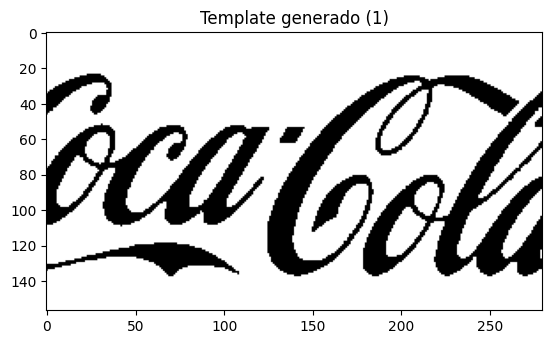

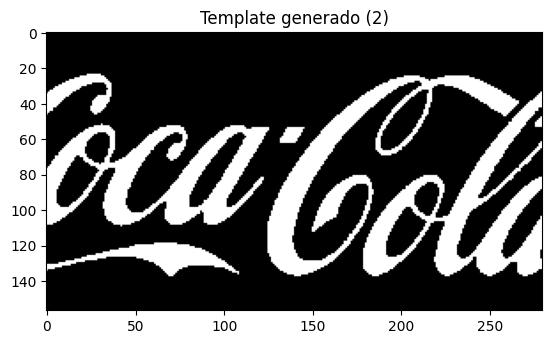

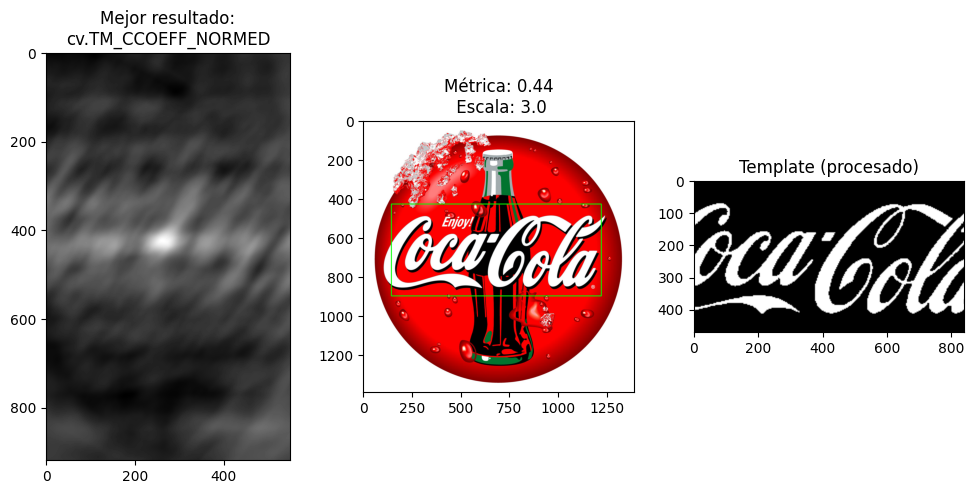

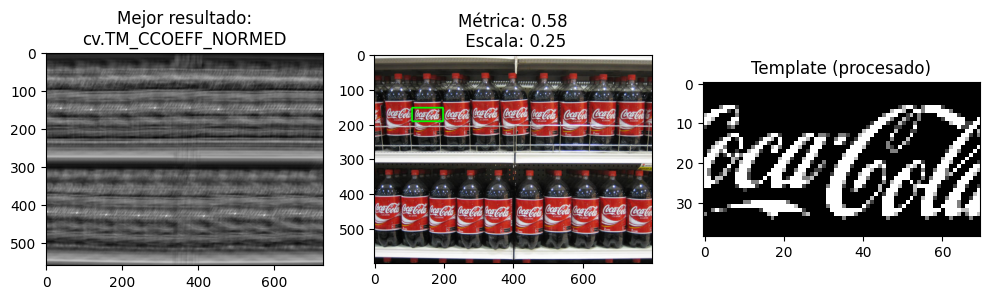

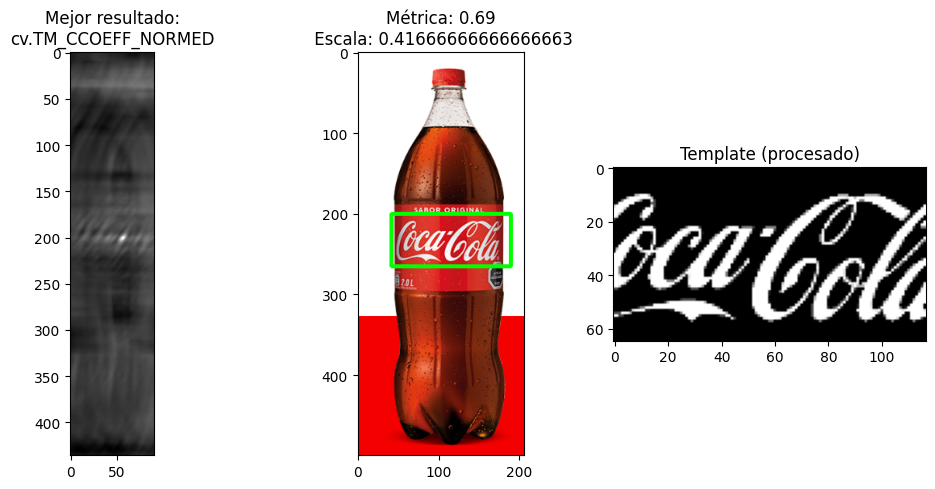

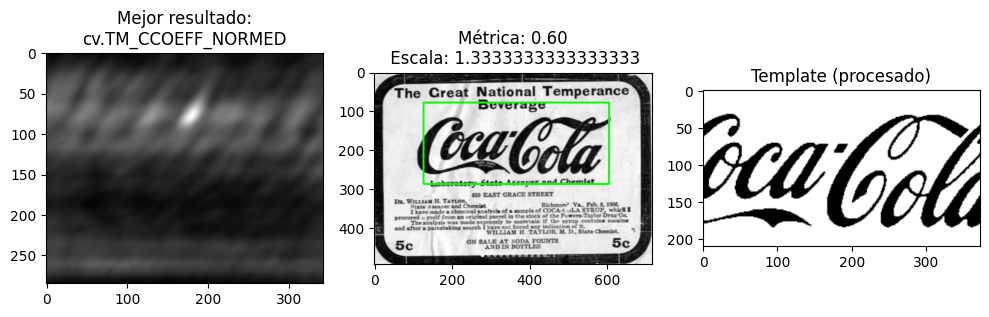

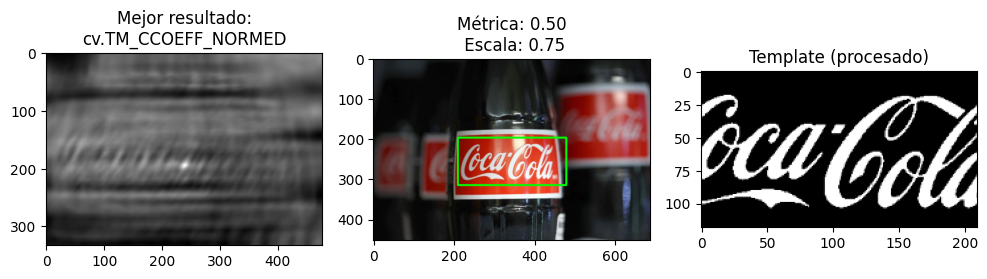

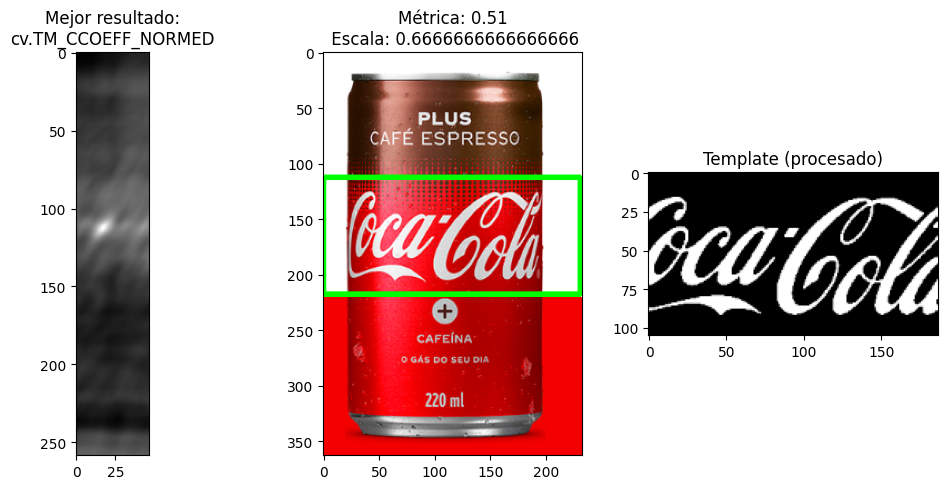

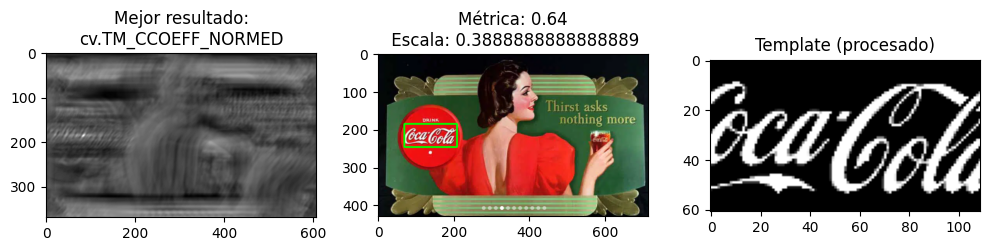

In [22]:
# process_algorithms = [
#   "cv.TM_CCOEFF",
#   "cv.TM_CCOEFF_NORMED", 
#   "cv.TM_CCORR", 
#   "cv.TM_CCORR_NORMED", 
#   "cv.TM_SQDIFF", 
#   "cv.TM_SQDIFF_NORMED"
#]
process_algorithms = ["cv.TM_CCOEFF_NORMED"]
find_logo_in_pictures(images_path, template_path, process_algorithms)
